# Figure 1
all data assumed to be in ../../data

## setup and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from scipy.stats import ks_2samp, pearsonr, linregress

from rna_secstruct import SecStruct

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_scatter_w_best_fit_line,
    plot_motif_boxplot_stripplot,
    publication_style_ax)



### added functions

In [2]:
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())


def r2(x, y):
    return pearsonr(x, y)[0] ** 2


In [3]:
def generate_small_plot(x_label, y_label):
    fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=600)
    ax.set_xlabel(x_label, labelpad=2)
    ax.set_ylabel(y_label, labelpad=2) 
    return fig, ax 

def format_small_plot(ax):
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)
    plt.subplots_adjust(left=0.3, bottom=0.21, top=0.98)

In [4]:
DATA_PATH = "../../data"

In [5]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2_combined.json")
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

In [6]:
df_construct["ln_r_data"] = np.log(df_construct["r_data"])
df_construct["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## plot data

### Figure 1B: construct to highlight diversity of structures. Find one with the most different motifs

In [7]:
def figure_1b(df_construct, ax):
    row = df_construct.iloc[7000].to_dict()
    row["sequence"] = row["sequence"][1:]
    row["structure"] = row["structure"][1:]
    row["data"] = row["data"][1:]
    ax = plot_pop_avg_from_row(row, ax=ax)
    ax.set_xlabel("Nucleotide", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
    ax.set_xlim(-1, 112)
    ax.tick_params(axis="x", which="both", bottom=False, top=False, size=-1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=4)

KeyError: 'sequence'

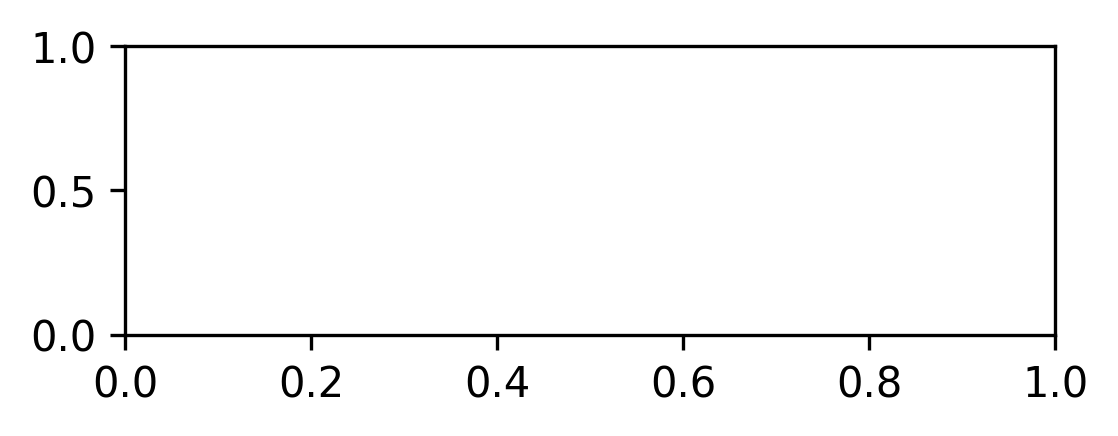

In [8]:
fig, ax = plt.subplots(figsize=(4.00, 1.25), dpi=300)
figure_1b(df_construct, ax)
plt.savefig("pngs/figure_1b.png", dpi=600)

### Figure 1C: mutation fraction reproducibility

In [ ]:
def figure_1c(df_construct, df_construct_2, ax):
    # prepare data for plot
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name")
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    # generate plot 
    plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
    ax.set_xlabel("Mut. Frac. Run 1", labelpad=2)
    ax.set_ylabel("Mut. Frac. Run 2", labelpad=2)
    ax.set_xticks([0.00, 0.20, 0.40])
    ax.set_yticks([0.00, 0.20, 0.40])
    format_small_plot(ax)

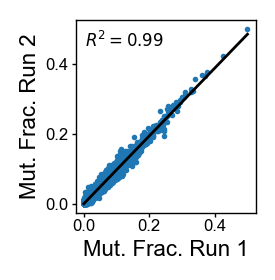

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1c(df_construct, df_construct_2, ax)
plt.savefig("pngs/figure_1c.png", dpi=600, pad_inches=0.0)

### Figure 1D: histogram of DMS reactivity in Ln space

In [ ]:
def figure_1d(df, ax):
    ax.hist(df["ln_r_data"], bins=25)
    ax.set_yscale("log")
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_yticks([10, 100, 1000, 10000])
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)

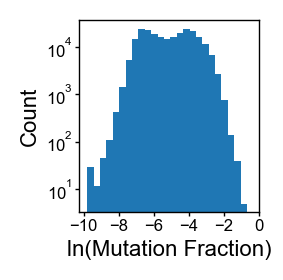

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1d(df, ax)
plt.savefig("pngs/figure_1d.png", dpi=600, pad_inches=0.0)

### Figure 1E: how often does each motif occur

In [ ]:
def figure_1e(df_motif, ax):
    data = []
    for i, group in df_motif.groupby("m_sequence"):
        data.append([i, len(group)])
    df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])
    ax.set_xlabel("Motif Count", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    plt.hist(df_counts["count"], bins=100)
    format_small_plot(ax)

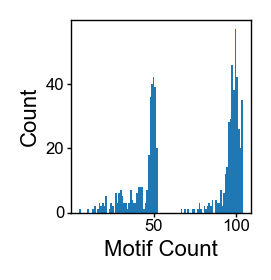

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1e(df_motif, ax)
plt.savefig("pngs/figure_1e.png", dpi=600, pad_inches=0.0)

### Figure 1F: example motif

In [ ]:
print(df["m_sequence"].unique())

['AAA&UAU' 'AAA&UCU' 'AAA&UGU' 'AAAA&UAAU' 'AAAA&UACU' 'AAAA&UAGU'
 'AAAA&UCAU' 'AAAA&UCGU' 'AAAA&UGAU' 'AAAA&UGGU' 'AAAC&GAAU' 'AAAC&GACU'
 'AAAC&GAGU' 'AAAC&GCAU' 'AAAC&GCGU' 'AAAC&GCU' 'AAAC&GGAU' 'AAAC&GGGU'
 'AAACG&CUAU' 'AAAG&CAAU' 'AAAG&CACU' 'AAAG&CAGU' 'AAAG&CCAU' 'AAAG&CCGU'
 'AAAG&CGAU' 'AAAG&CGGU' 'AAAGG&UACU' 'AAAU&AAAU' 'AAAU&AACU' 'AAAU&AAGU'
 'AAAU&ACAU' 'AAAU&ACGU' 'AAAU&AGAU' 'AAAU&AGGU' 'AAC&GAU' 'AAC&GCU'
 'AACA&UAAU' 'AACA&UACU' 'AACA&UCAU' 'AACA&UCCU' 'AACA&UUAU' 'AACA&UUCU'
 'AACC&GAAU' 'AACC&GACU' 'AACC&GCAU' 'AACC&GCCU' 'AACC&GUAU' 'AACC&GUCU'
 'AACG&CAAU' 'AACG&CACU' 'AACG&CCAU' 'AACG&CCCU' 'AACG&CUAU' 'AACG&CUCU'
 'AACG&CUGU' 'AACU&AACU' 'AACU&ACAU' 'AACU&ACCU' 'AACU&AUAU' 'AACU&AUCU'
 'AACU&AUGU' 'AAG&CAU' 'AAG&CCU' 'AAG&CGU' 'AAG&CU' 'AAGA&UAAU'
 'AAGA&UGAU' 'AAGC&GAAU' 'AAGC&GGAU' 'AAGCAG&UCAGGU' 'AAGG&CAAU'
 'AAGG&CGAU' 'AAGGAA&UGU' 'AAGU&AGAU' 'AAU&AAU' 'AAU&ACU' 'AAU&AGU'
 'AAU&GAU' 'AAUA&UCAU' 'AAUA&UCCU' 'AAUA&UUAU' 'AAUA&UUCU' 'AAUA&UUGU'
 'AAUC&GCAU

In [ ]:
def figure_1f(df, ax):
    df_motif_example = df[df["m_sequence"] == "GGGAAAG&UAACAC"]
    plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    format_small_plot(ax)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


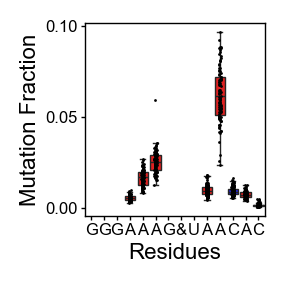

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1f(df, ax)
plt.savefig("pngs/figure_1f.png", dpi=600, pad_inches=0.0)

### Figure 1G: reactivity avg vs std

In [ ]:
def figure_1g(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append([group["r_data"].mean(), group["r_data"].std()])
    df_data = pd.DataFrame(data, columns=["mean", "std"])
    plot_scatter_w_best_fit_line(np.log(df_data["mean"]), np.log(df_data["std"]), ax=ax)
    ax.set_xlabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
    ax.set_yticks([-2, -4, -6, -8])
    ax.set_xticks([-8, -6, -4, -2])
    format_small_plot(ax)

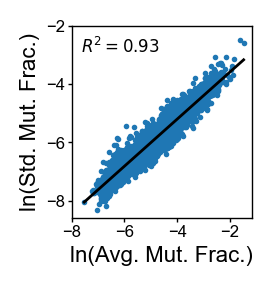

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1g(df, ax)
plt.savefig("pngs/figure_1g.png", dpi=600, pad_inches=0.0)

### Figure 1H: coefficient of variation

In [ ]:
def figure_1h(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append(group["r_data"].std() / group["r_data"].mean())
    plt.hist(data, bins=50)
    format_small_plot(ax)
    ax.set_xlabel("Coefficient of Variation", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)

In [ ]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())
np.mean(data)

0.3942839835926987

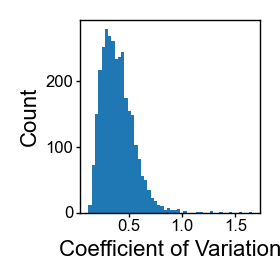

In [ ]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1h(df, ax)
plt.savefig("pngs/figure_1h.png", dpi=600, pad_inches=0.0)

### Figure 1B-H: all together

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:378: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


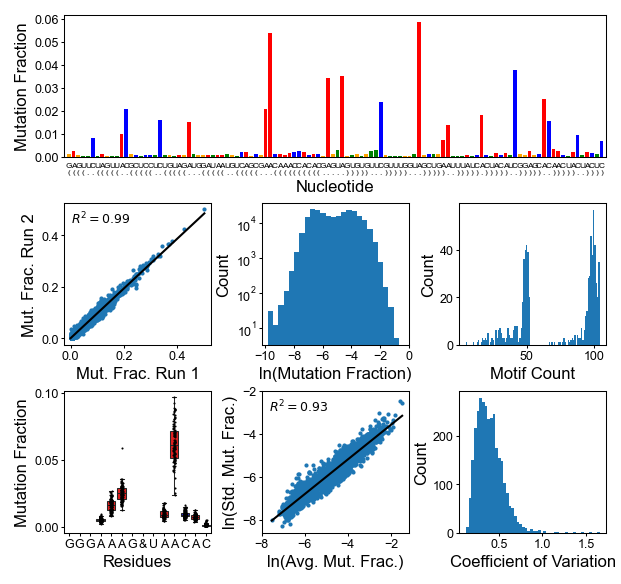

In [ ]:
fig = plt.figure(figsize=(4.25, 4), dpi=150)
gs = gridspec.GridSpec(3, 3)
gs_flat = [gs[0, :], gs[1, 0], gs[1, 1], gs[1, 2], gs[2, 0], gs[2, 1], gs[2, 2]]
# First row: one column
ax1 = fig.add_subplot(gs_flat[0])  
figure_1b(df_construct, ax1)
# Second row: three columns
ax2 = fig.add_subplot(gs[1, 0])
figure_1c(df_construct, df_construct_2, ax2)
ax3 = fig.add_subplot(gs[1, 1])
figure_1d(df, ax3)
ax4 = fig.add_subplot(gs[1, 2])
figure_1e(df_motif, ax4)
# Third row: three columns
ax5 = fig.add_subplot(gs[2, 0])
figure_1f(df, ax5)
ax6 = fig.add_subplot(gs[2, 1])
figure_1g(df, ax6)
ax7 = fig.add_subplot(gs[2, 2])
figure_1h(df, ax7)

# Show the plot
gs.tight_layout(fig, h_pad=0.25, w_pad=0.25)
plt.savefig("pngs/figure_1.png", dpi=600, pad_inches=0.0)